## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Step 1: Compute the camera calibration using chessboard images

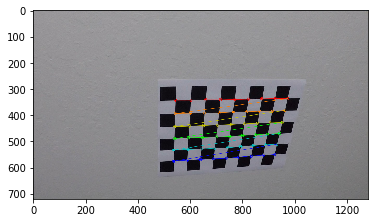

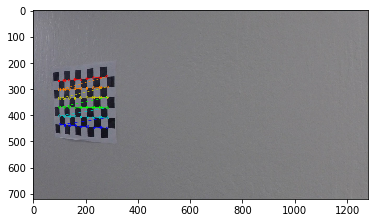

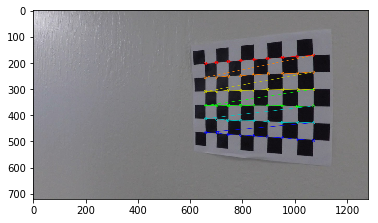

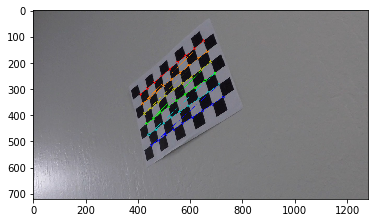

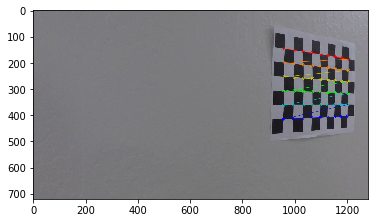

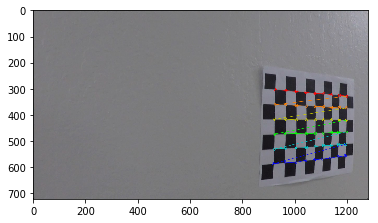

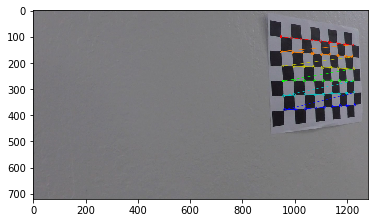

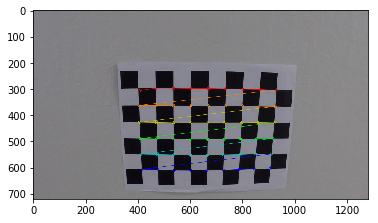

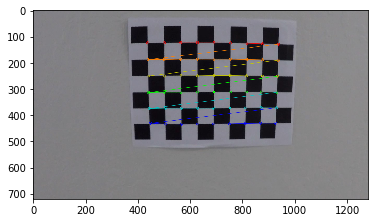

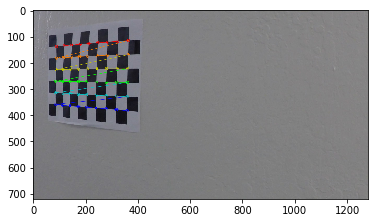

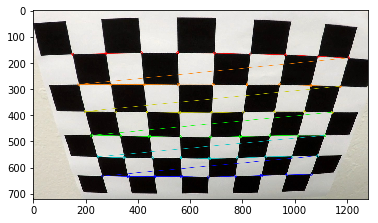

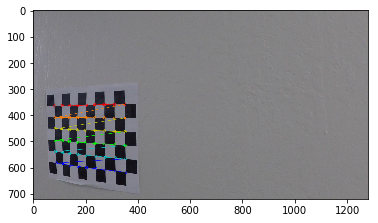

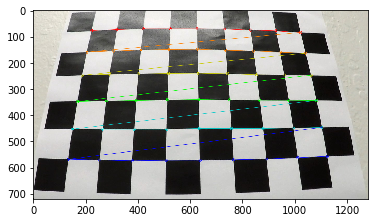

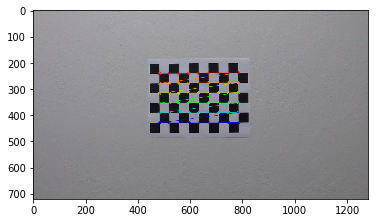

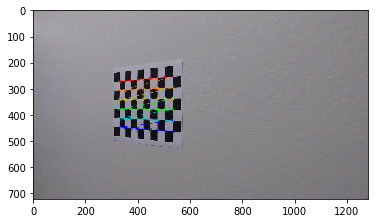

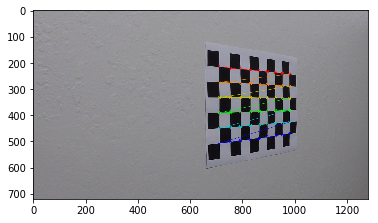

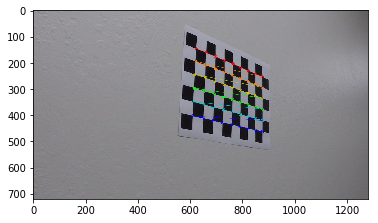

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        # RGB -> BGR
        img = img[...,::-1]
        plt.figure()
        plt.imshow(img)
        
        # Camera calibration, given object points, image points, and the shape of the grayscale image
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Step 2: Undistort

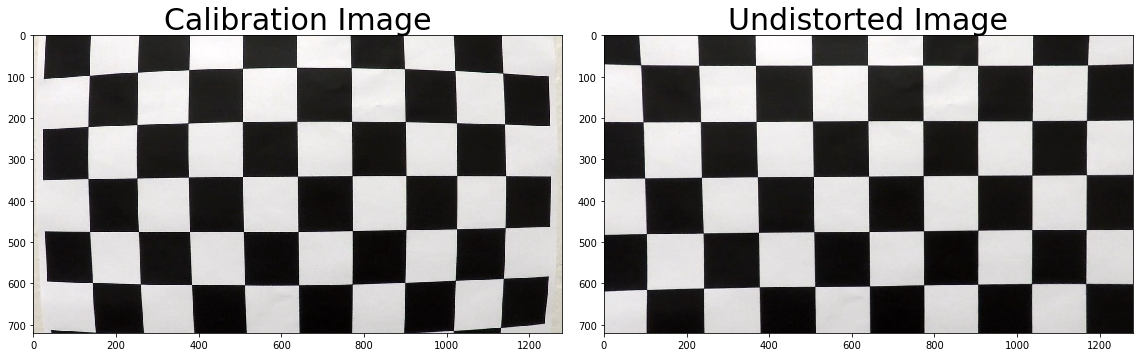

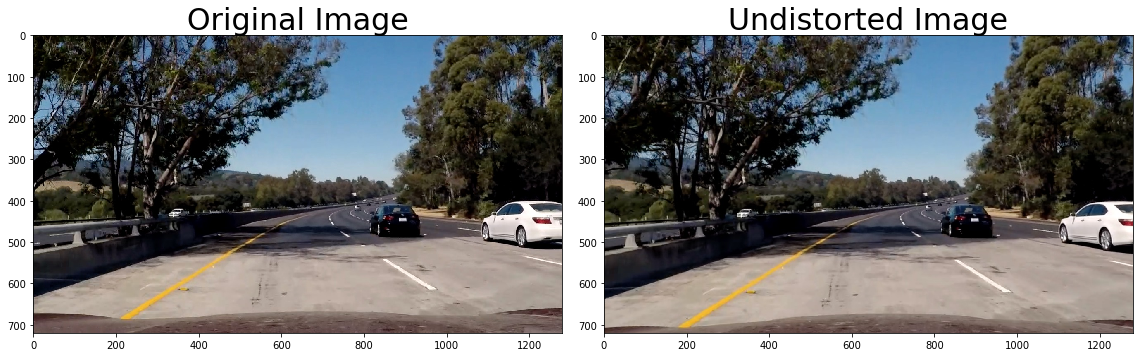

In [3]:
# Undistort sample image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Visualize undistortion
image_file = 'camera_cal/calibration1.jpg'
img = cv2.imread(image_file)
# RGB -> BGR 
img = img[...,::-1]   
undistor = undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Calibration Image", fontsize=30)
ax1.imshow(img)
ax2.set_title("Undistorted Image", fontsize=30)
ax2.imshow(undistor)

# Visualize undistortion
image_file = 'test_images/test5.jpg'
img = cv2.imread(image_file)
# RGB -> BGR 
img = img[...,::-1]   
undistor = undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Original Image", fontsize=30)
ax1.imshow(img)
ax2.set_title("Undistorted Image", fontsize=30)
ax2.imshow(undistor)

## Step 3: Apply color transforms and gradient thresholds

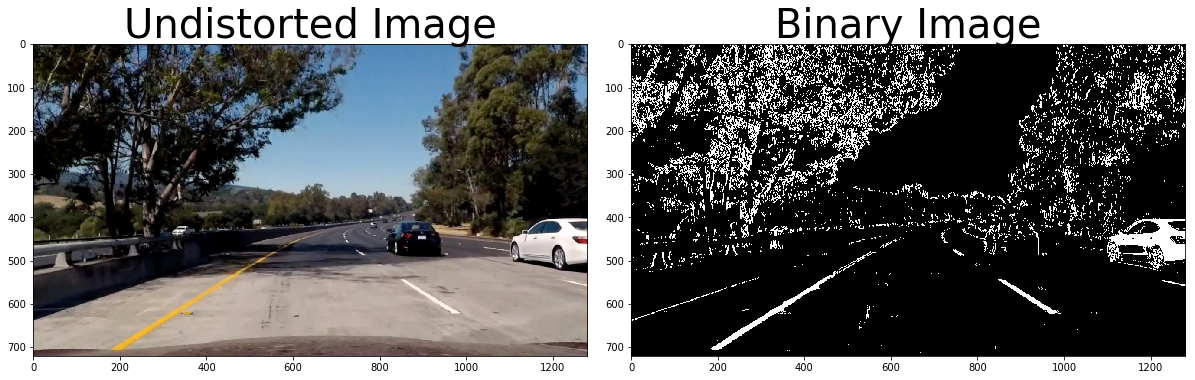

In [4]:
# Edit this function to create your own pipeline.
def pipeline(image, r_thresh=(210, 255), s_thresh=(120, 255), sx_thresh=(20, 100)):
    image = np.copy(image)

    R = image[:,:,0]
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1 
    
    # Convert to HLS color space and separate the L channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # # Take the derivative in l
    sobell = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    # Absolute l derivative
    abs_sobell = np.absolute(sobell)
    scaled_sobel = np.uint8(255*abs_sobell/np.max(abs_sobell))
    
    # Threshold l gradient
    slbinary = np.zeros_like(scaled_sobel)
    slbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(slbinary)
    combined_binary[(r_binary == 1) | (slbinary == 1)] = 1   
    return combined_binary
    
binary = pipeline(undistor)

# Visualize the pipeline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()

ax1.imshow(undistor)
ax1.set_title('Undistorted Image', fontsize=40)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Step 4: Perspective transform

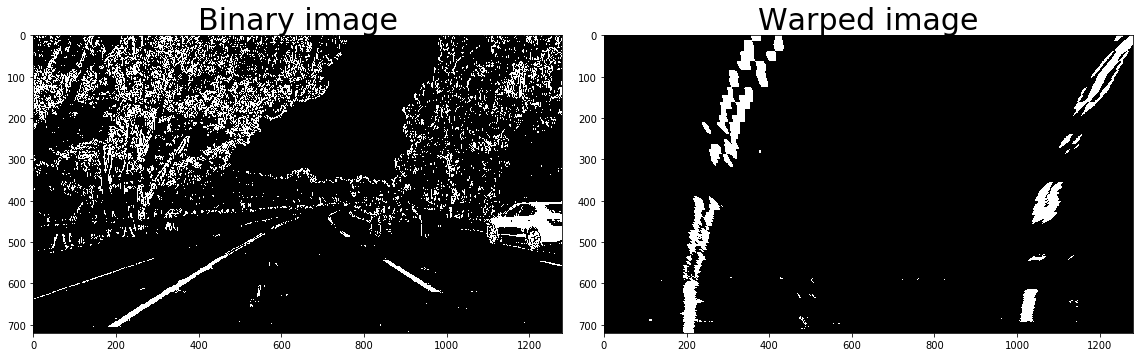

In [5]:
def warper(image):
    img_size = (image.shape[1], img.shape[0])
    
    # define source and destination points for transform
    src = np.float32([[[ 610,  450]], 
                      [[ 680,  450]], 
                      [[ img_size[0]-300,  680]],
                      [[ 380,  680]]])

    # offset for dst points
    offset = 350 
    dst = np.float32([[offset, 0], 
                      [img_size[0]-offset, 0], 
                      [img_size[0]-offset, img_size[1]], 
                      [offset, img_size[1]]])
    
    # Obtain M, the transform matrix using cv2.getPerspectiveTransform()
    persp_M = cv2.getPerspectiveTransform(src, dst)
    
    # Obtain Minv, the inverse using cv2.getPerspectiveTransform()
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warpe = cv2.warpPerspective(image, persp_M, img_size)
    
    # Return the resulting image and matrices
    return warpe, persp_M, M_inv

warped, M, Minv = warper(binary)

# Visualize warp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Binary image", fontsize=30)
ax1.imshow(binary, cmap='gray')
ax2.set_title("Warped image", fontsize=30)
ax2.imshow(warped, cmap='gray')

## Step 5: Detect lane panels and fit polynomials to get lane boundaries

Left and right points
Left:  [214.0, 210.0, 226.0, 241.0, 240.0, 293.0, 307.0, 326.0, 354.0]
Right:  [1031.0, 1025.0, 1045.0, 1064.0, 1075.0, 1127.0, 1163.0, 1198.0, 1250.0]


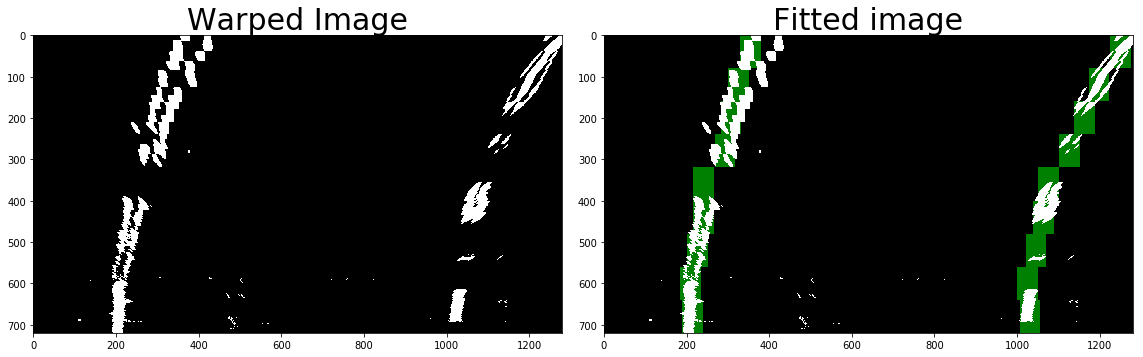

In [6]:
# window settings
window_width = 50
# Break image into 9 vertical layers since image height is 720
window_height = 80
# How much to slide left and right for searching
margin = 100

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    # Store the (left,right) window centroid positions per level
    window_centroids = []
    leftx = []
    rightx = []
    
    # Create our window template that we will use for convolutions
    window = np.ones(window_width)   
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))  
    leftx.append(l_center)
    rightx.append(r_center)
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        prev_l_center = l_center        
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset      
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        prev_r_center = r_center
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        leftx.append(l_center)
        rightx.append(r_center)

    return window_centroids, leftx, rightx

window_centroids, leftx, rightx = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results    
    # add both left and right window pixels together
    template = np.array(r_points+l_points,np.uint8)
    # create a zero color channel
    zero_channel = np.zeros_like(template)
    # make window pixels green
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8)
    out_img = np.dstack((warped, warped, warped))*255
    # making the original road pixels 3 color channels
    warpage = np.array(out_img,np.uint8)
    # overlay the orignal road image with window results
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0)
    
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
print('Left and right points')
print ('Left: ',leftx)
print ('Right: ',rightx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Warped Image", fontsize=30)
ax1.imshow(warped, cmap='gray')
ax2.set_title("Fitted image", fontsize=30)
ax2.imshow(output)

## Step 6: Determine curvature and position of vehicle with respect to center

Left: 809.6705067105296 m - Right: 406.144074909833 m


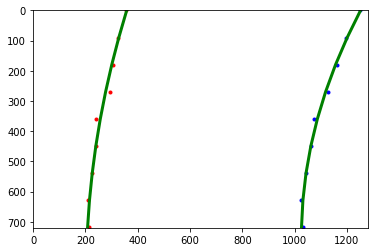

In [7]:
# To cover same y-range as image
ploty = np.linspace(0, 719, num=9)

def curvature(leftx, rightx):
    # Reverse to match top-to-bottom in y
    leftx = np.asarray(leftx[::-1])  
    # Reverse to match top-to-bottom in y
    rightx = np.asarray(rightx[::-1])  
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    position = ((rightx_int+leftx_int)/2)-50
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    # Meters per pixel in y dimension
    ym_per_pix = 30/720 
    # Meters per pixel in x dimension
    xm_per_pix = 3.7/700 

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return position, center, leftx, rightx, left_fitx, right_fitx, left_curverad, right_curverad

position, center, leftx, rightx, left_fitx, right_fitx, left_curverad, right_curverad = curvature(leftx, rightx)

# Visualize the data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis()

# Radius of curvature in meters
print('Left:',left_curverad, 'm - Right:', right_curverad, 'm')

## Step 7: Warp detected lanes onto original image with curvature and vehicle position

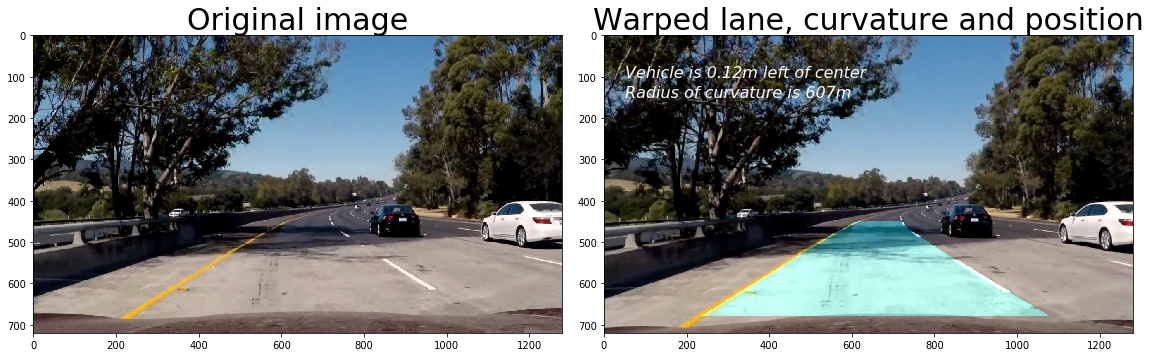

In [8]:
def warp_original(image, warp, persp_Minv, le_fitx, ri_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([le_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([ri_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,255))

    # Warp the blank back to original image space using Minv, the inverse perspective matrix
    newwarp = cv2.warpPerspective(color_warp, persp_Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Original image", fontsize=30)
ax1.imshow(img)
ax2.set_title("Warped lane, curvature and position", fontsize=30)

if position == 640:
    ax2.text(50, 100, 'Vehicle is in the center', style='italic', color='white', fontsize=16)
elif position < 640:
    ax2.text(50, 100, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700),
         style='italic', color='white', fontsize=16)
else:
    ax2.text(50, 100, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700),
         style='italic', color='white', fontsize=16)

ax2.text(50, 150, 'Radius of curvature is {}m'.format(int((left_curverad + right_curverad)/2)), 
         style='italic', color='white', fontsize=16)

ax2.imshow(warp_original(undistor, warped, Minv, left_fitx, right_fitx))

## Step 8: Define a Line Class for Storing Data

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])] 
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # number of detected pixels
        self.px_count = None

## Step 9: Define final pipeline

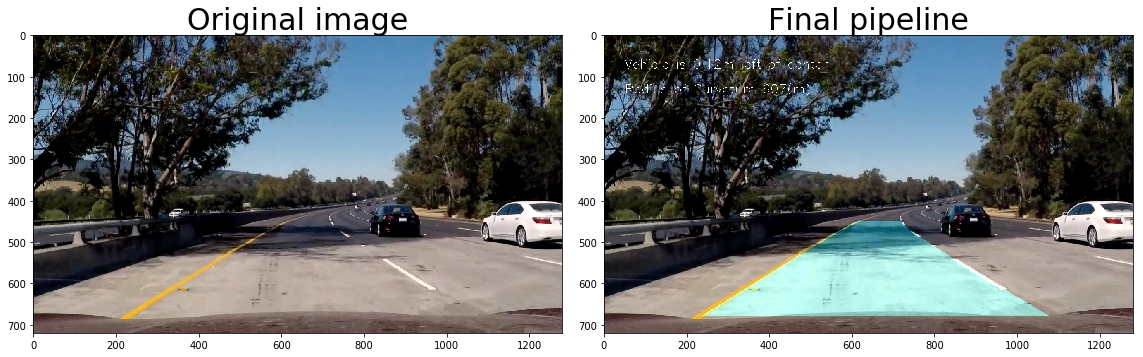

In [10]:
def final_pipeline(im):
    final_undistorted = undistort(im)
    final_binary = pipeline(final_undistorted)
    final_warped, final_M, final_Minv = warper(final_binary)
    window_cent, lex, rix = find_window_centroids(final_warped, window_width, window_height, margin)      
    position, center, leftx, rightx, left_lane.recent_xfitted, right_lane.recent_xfitted, left_lane.radius_of_curvature, right_lane.radius_of_curvature = curvature(lex, rix)

    alpha = 0.5
    if left_lane.bestx is None:
        left_lane.bestx = left_lane.recent_xfitted
    else :    
        left_lane.recent_xfitted = left_lane.recent_xfitted * ( 1 - alpha) + alpha * left_lane.bestx
        
    if right_lane.bestx is None:
        right_lane.bestx = right_lane.recent_xfitted
    else :    
        right_lane.recent_xfitted = right_lane.recent_xfitted * ( 1 - alpha) + alpha * right_lane.bestx  
             
    left_lane.detected = False
    right_lane.detected = False 
    
    max_distance = 0  
    min_distance = 10000
    for i in range(len(left_lane.recent_xfitted)) : 
        point_distance = right_lane.recent_xfitted[i] - left_lane.recent_xfitted[i]
        if point_distance > max_distance:
            max_distance = point_distance
        if point_distance < min_distance:
            min_distance = point_distance    
        
    if (min_distance > 710) and (max_distance < 900):
        left_lane.detected = True
        right_lane.detected = True              
        
    if not left_lane.detected:
        left_lane.recent_xfitted = left_lane.bestx
    else:
        left_lane.bestx = left_lane.recent_xfitted
    if not right_lane.detected:
        right_lane.recent_xfitted = right_lane.bestx
    else:
        right_lane.bestx = right_lane.recent_xfitted
    
    result = warp_original(im, final_warped, final_Minv, left_lane.recent_xfitted, right_lane.recent_xfitted)    
    
    # Print distance from center on video
    if (center*3.7/700) < 0.01:
        cv2.putText(result, 'Vehicle is in the center', (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    elif center < 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(center*3.7/700), (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(center*3.7/700), (50,80),
                 fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
        
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2)), (50,140),
             fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 1)
    
    return result

# Visualize final pipeline
left_lane = Line()
right_lane = Line()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Original image", fontsize=30)
ax1.imshow(img)
ax2.set_title("Final pipeline", fontsize=30)
ax2.imshow(final_pipeline(img))

## Step 10: Apply pipeline on project video

In [11]:
left_lane = Line()
right_lane = Line()
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(final_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:33<00:00,  8.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 34s
